In [1]:
print("""
@File         : ex8.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-04-02 22:03:40
@Email        : cuixuanstephen@gmail.com
@Description  : Apply the SARIMA(p,d,q)(P,D,Q)m model on the Johnson & Johnson dataset
""")


@File         : ex8.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-04-02 22:03:40
@Email        : cuixuanstephen@gmail.com
@Description  : Apply the SARIMA(p,d,q)(P,D,Q)m model on the Johnson & Johnson dataset



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from typing import Union
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../data/jj.csv")
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


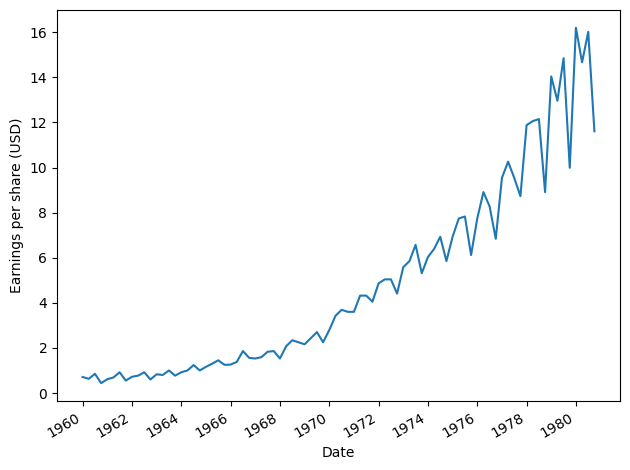

In [4]:
fig, ax = plt.subplots()
ax.plot(df.date, df["data"])
ax.set_xlabel("Date")
ax.set_ylabel("Earnings per share (USD)")
plt.xticks(
    np.arange(0, 81, 8),
    [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980],
)
fig.autofmt_xdate()
plt.tight_layout()

Since we have quarterly data, $m=4$.

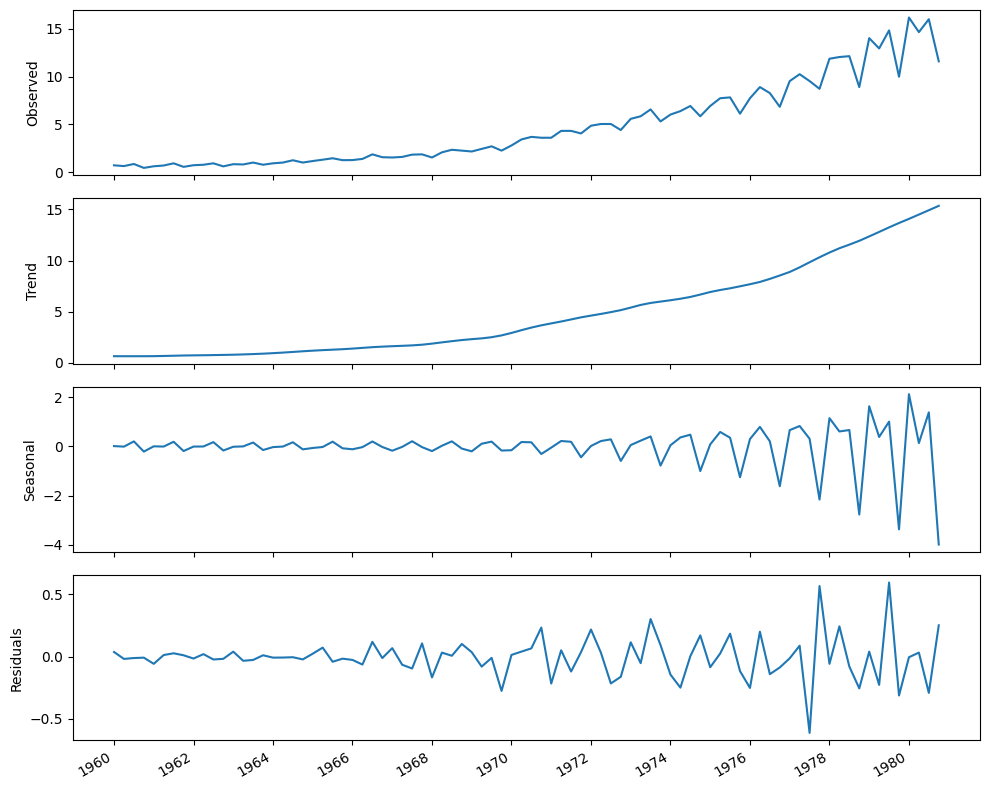

In [5]:
decomposition = STL(
    df["data"], period=4
).fit()  # Period is 4 since we have quarterly data

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
axes[0].plot(decomposition.observed)
axes[0].set_ylabel("Observed")

axes[1].plot(decomposition.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(decomposition.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(decomposition.resid)
axes[3].set_ylabel("Residuals")

plt.xticks(
    np.arange(0, 81, 8),
    [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980],
)

fig.autofmt_xdate()
plt.tight_layout()

In [6]:
ad_fuller_result = adfuller(df["data"])
print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistic: 2.742016573457473
p-value: 1.0


The series is not stationary, so let's apply differencing.

In [7]:
df_diff = np.diff(df["data"], n=1)
ad_fuller_result = adfuller(df_diff)

print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistic: -0.4074097636380251
p-value: 0.908854241691134


The series is still not stationary. Let's try seasonal differencing now.(尝试，并不是固定准则)

In [8]:
# 尝试季节性差分
df_diff_seasonal_diff = np.diff(df_diff, n=4)
ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistic: -6.032499262653167
p-value: 1.4070571055429944e-07


The series is now stationary. Therefore, we set $d=1$ and $D=1$.

In [9]:
def optimize_SARIMA(
    endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int
) -> pd.DataFrame:
    results = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False,
            ).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ["(p,q,P,Q)", "AIC"]

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

    return result_df

Keep the last year to test the predictions.

In [10]:
train = df[:-4]
test = df[-4:].copy()
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 4  # We have quarterly data, so 4 data points per seasonal cycle

SARIMA_result_df = optimize_SARIMA(train["data"], SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [02:11<00:00,  1.94it/s]


,"(p,q,P,Q)",AIC
0,"(3, 0, 2, 1)",88.829675
1,"(1, 2, 0, 0)",89.609996
2,"(3, 1, 0, 0)",89.677549
3,"(1, 3, 0, 0)",89.734025
4,"(2, 2, 0, 0)",90.178107
...,...,...
251,"(0, 0, 3, 2)",136.748819
252,"(0, 0, 2, 3)",136.768679
253,"(0, 0, 0, 0)",137.133568
254,"(0, 0, 1, 3)",137.761947
